## INVENTORY-DEMAND-FORECASTING

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sb 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn import metrics 
from sklearn.svm import SVC 
from xgboost import XGBRegressor 
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error as mae 

reading file from folder(imported from kaggle)


In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
df.isna().count()

date     913000
store    913000
item     913000
sales    913000
dtype: int64

In [6]:
df.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [7]:
df.shape

(913000, 4)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [9]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [10]:
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"] = parts[0].astype(int)
df["month"] = parts[1].astype(int)
df["day"] = parts[2].astype(int)
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [11]:
from datetime import datetime 
import calendar 
      
def weekend_or_weekday(year,month,day): 
      
    d = datetime(year,month,day) 
    if d.weekday()>4: 
        return 1
    else: 
        return 0
  
df["weekend"] = df.apply(lambda x:weekend_or_weekday(x['year'], x['month'], x['day']), axis=1) 
df.head()

,date,store,item,sales,year,month,day,weekend
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,1


In [12]:
from datetime import date
import holidays
indian_holidays = holidays.country_holidays('IN')
def is_holiday(x):
    if indian_holidays.get(x):
        return 1
    else:
        return 0
df["holiday"] = df.date.apply(is_holiday)
df.head()

,date,store,item,sales,year,month,day,weekend,holiday
0,2013-01-01,1,1,13,2013,1,1,0,0
1,2013-01-02,1,1,11,2013,1,2,0,0
2,2013-01-03,1,1,14,2013,1,3,0,0
3,2013-01-04,1,1,13,2013,1,4,0,0
4,2013-01-05,1,1,10,2013,1,5,1,0


adding cyclic features

In [13]:
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12)) 
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12)) 
df.head()

,date,store,item,sales,year,month,day,weekend,holiday,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025


In [14]:
def which_day(year, month, day): 
      
    d = datetime(year,month,day) 
    return d.weekday() 
  
df['weekday'] = df.apply(lambda x: which_day(x['year'], x['month'],x['day']),axis=1) 
df.head(10)

,date,store,item,sales,year,month,day,weekend,holiday,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0,0.5,0.866025,1
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025,2
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025,3
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025,4
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025,5
5,2013-01-06,1,1,12,2013,1,6,1,0,0.5,0.866025,6
6,2013-01-07,1,1,10,2013,1,7,0,0,0.5,0.866025,0
7,2013-01-08,1,1,9,2013,1,8,0,0,0.5,0.866025,1
8,2013-01-09,1,1,12,2013,1,9,0,0,0.5,0.866025,2
9,2013-01-10,1,1,9,2013,1,10,0,0,0.5,0.866025,3


In [15]:
df.drop("date",axis =1, inplace = True)

In [16]:
df.head(5)

,store,item,sales,year,month,day,weekend,holiday,m1,m2,weekday
0,1,1,13,2013,1,1,0,0,0.5,0.866025,1
1,1,1,11,2013,1,2,0,0,0.5,0.866025,2
2,1,1,14,2013,1,3,0,0,0.5,0.866025,3
3,1,1,13,2013,1,4,0,0,0.5,0.866025,4
4,1,1,10,2013,1,5,1,0,0.5,0.866025,5


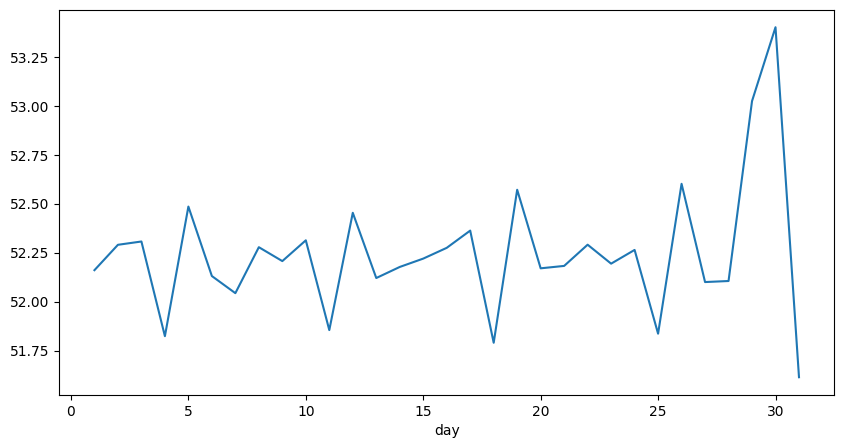

In [17]:
plt.figure(figsize=(10,5)) 
df.groupby('day').mean()['sales'].plot() 
plt.show()

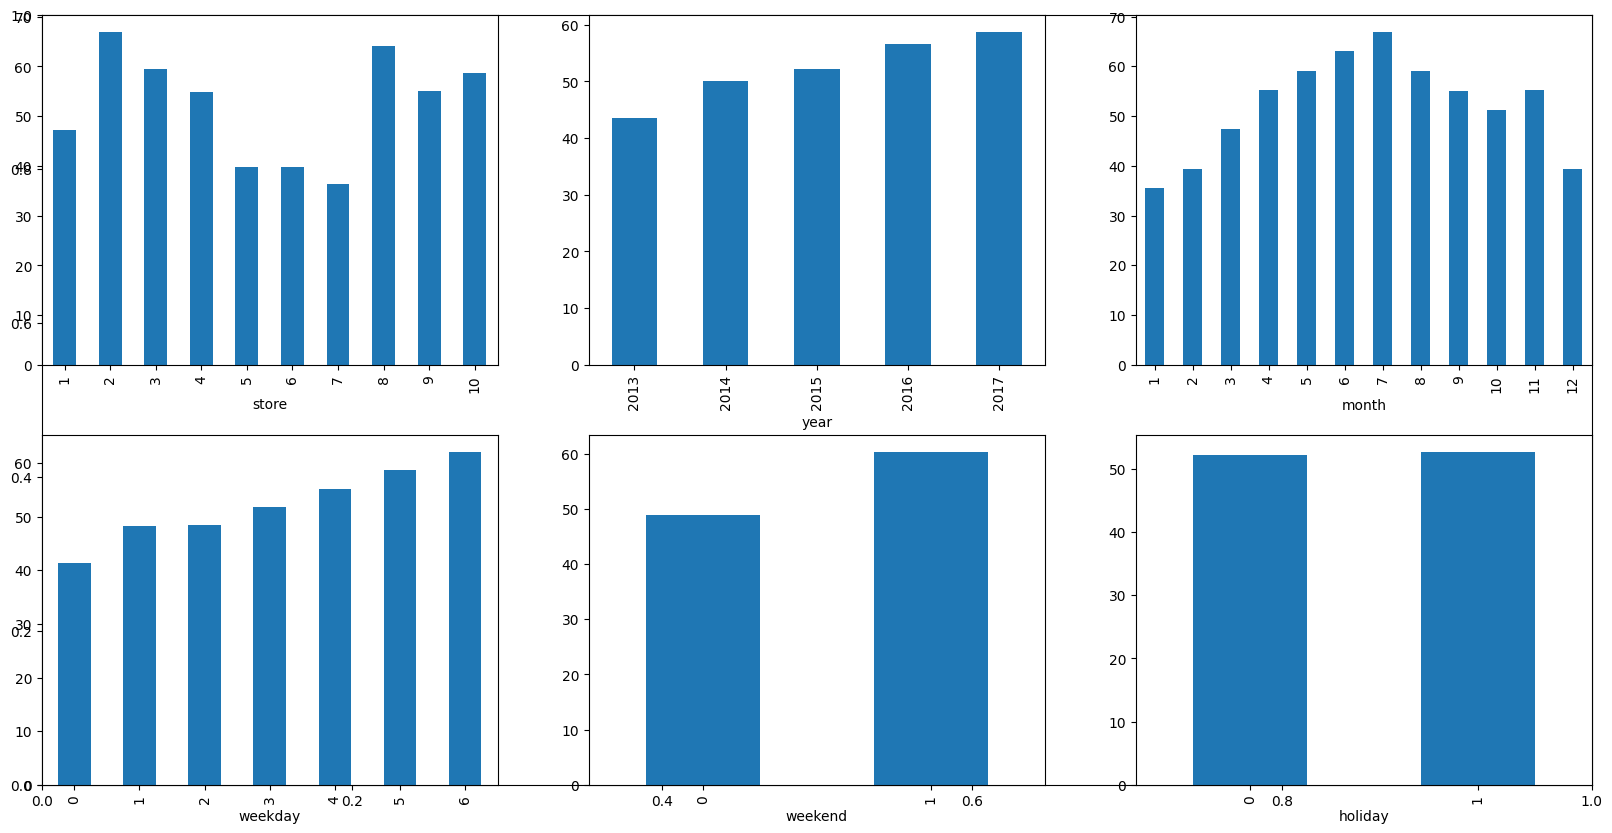

In [18]:
features = ['store', 'year', 'month','weekday', 'weekend', 'holiday'] 
  
plt.subplots(figsize=(20, 10)) 
for i, col in enumerate(features): 
    plt.subplot(2, 3, i+1) 
    df.groupby(col).mean()['sales'].plot.bar() 
plt.show() 

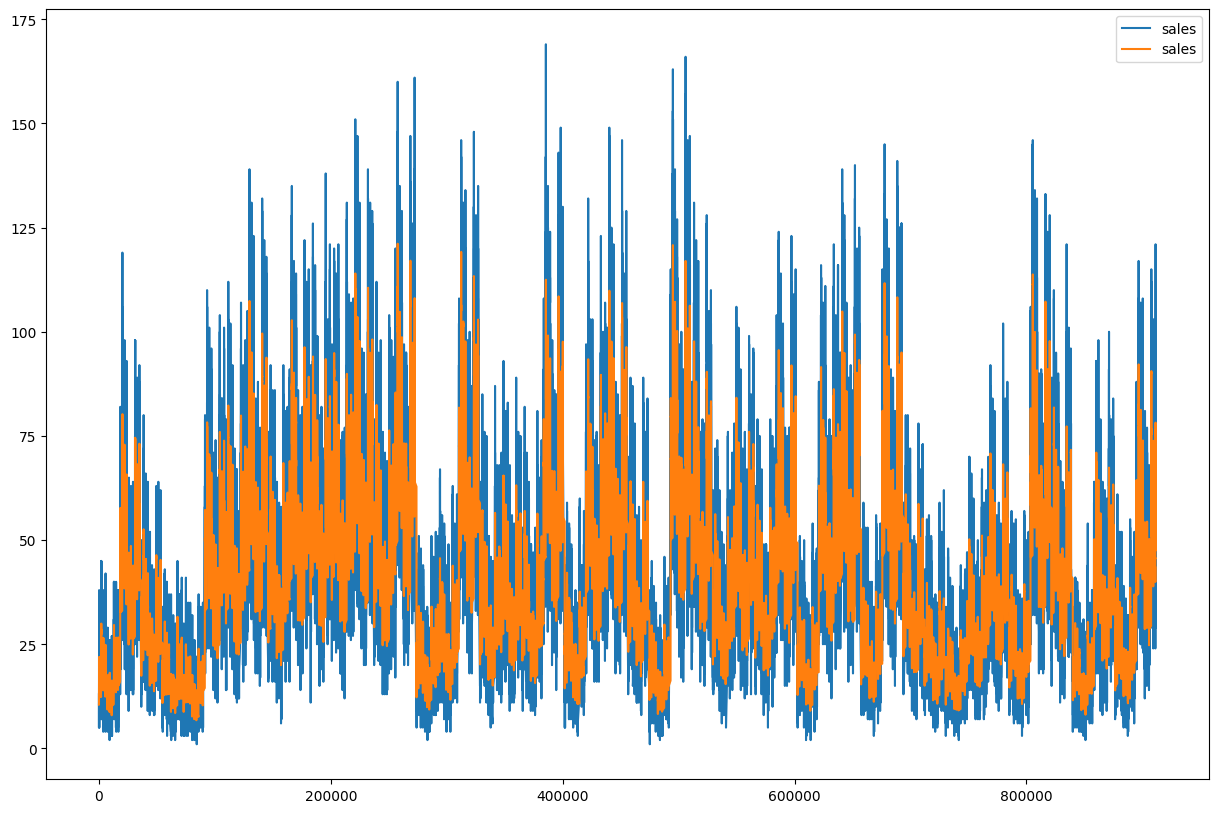

In [19]:
plt.figure(figsize=(15, 10)) 
  
# Calculating Simple Moving Average  
# for a window period of 30 days 
window_size = 30
data = df[df['year']==2013] 
windows = data['sales'].rolling(window_size) 
sma = windows.mean() 
sma = sma[window_size - 1:] 
  
data['sales'].plot() 
sma.plot() 
plt.legend() 
plt.show()

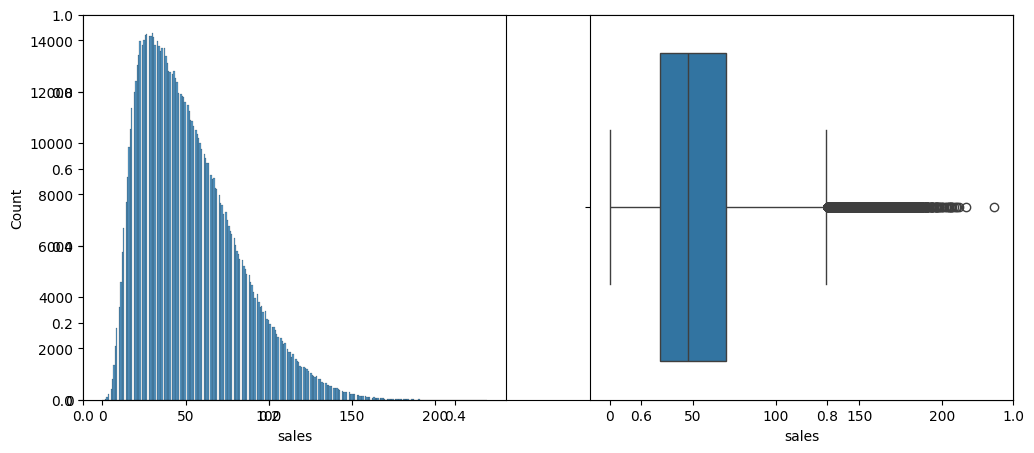

In [27]:
plt.subplots(figsize=(12, 5)) 
plt.subplot(1, 2, 1) 
sb.histplot(df['sales']) 
  
plt.subplot(1, 2, 2) 
sb.boxplot(x=df['sales']) 
plt.show() 

There are some outliers present which we can see above.


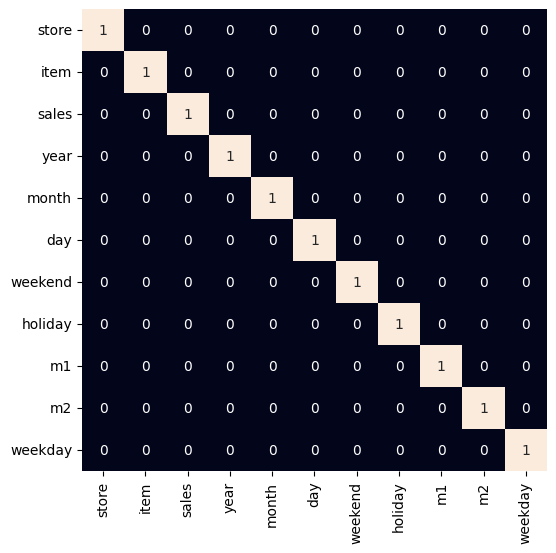

In [30]:
plt.figure(figsize=(6, 6)) 
sb.heatmap(df.corr() > 0.8, 
           annot=True, 
           cbar=False) 
plt.show() 


removing outliers


In [31]:
df = df[df['sales']<140]

In [32]:
df.head()

,store,item,sales,year,month,day,weekend,holiday,m1,m2,weekday
0,1,1,13,2013,1,1,0,0,0.5,0.866025,1
1,1,1,11,2013,1,2,0,0,0.5,0.866025,2
2,1,1,14,2013,1,3,0,0,0.5,0.866025,3
3,1,1,13,2013,1,4,0,0,0.5,0.866025,4
4,1,1,10,2013,1,5,1,0,0.5,0.866025,5


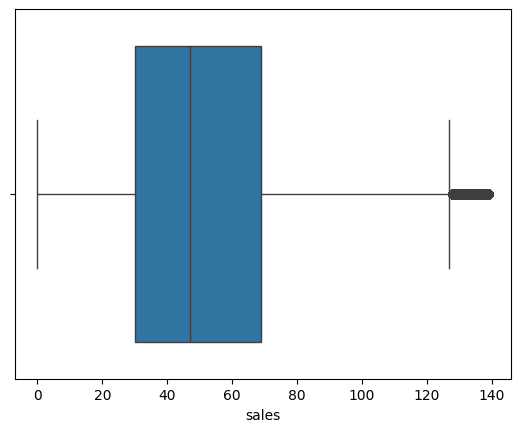

In [34]:
sb.boxplot(x=df['sales']) 
plt.show() 

In [35]:
features = df.drop(['sales', 'year'], axis=1) 
target = df['sales'].values 
  
  
X_train, X_val, Y_train, Y_val = train_test_split(features, target, 
                                                  test_size = 0.05, 
                                                  random_state=22) 
X_train.shape, X_val.shape

((861170, 9), (45325, 9))

In [36]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_val = scaler.transform(X_val)

In [37]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()] 
  
for i in range(4): 
    models[i].fit(X_train, Y_train) 
  
    print(f'{models[i]} : ') 
  
    train_preds = models[i].predict(X_train) 
    print('Training Error : ', mae(Y_train, train_preds)) 
  
    val_preds = models[i].predict(X_val) 
    print('Validation Error : ', mae(Y_val, val_preds)) 
    print() 

LinearRegression() : 
Training Error :  20.902989838083602
Validation Error :  20.97163963254154

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Error :  6.902142131234314
Validation Error :  6.9201690247120675

Lasso() : 
Training Error :  21.015028699769758
Validation Error :  21.07151